In [1]:
import numpy as np
import pandas as pd
from dask import dataframe as dd
import matplotlib.pyplot as plt
from scipy.stats import kendalltau, rankdata, norm
# import fastHDMI as mi
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, SplineTransformer
from sklearn.linear_model import LassoCV, ElasticNetCV, RidgeCV, LarsCV, LassoLarsCV, LogisticRegressionCV
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, roc_auc_score
import multiprocess as mp
from tqdm import tqdm
import os

# Calculate MI for ABIDE data age and diagnosis outcome
## this block is only to be run on Compute Canada

In [2]:
from pathlib import Path


def engine_and_share_memory_status(mem_setting):
    if mem_setting == "high_mem":
        return "c", False
    elif mem_setting == "share_mem":
        return "c", True
    elif mem_setting == "dask":
        return "dask", False


def job_generator(mem_setting, outcome):
    py_1 = r"""import numpy as np
import pandas as pd
from dask import dataframe as dd
import matplotlib.pyplot as plt
from scipy.stats import kendalltau, rankdata, norm
import fastHDMI as mi
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, SplineTransformer
from sklearn.linear_model import LassoCV, ElasticNetCV, RidgeCV, LarsCV, LassoLarsCV, LogisticRegressionCV
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, roc_auc_score
import multiprocess as mp
from tqdm import tqdm
import os

csv_file = os.environ["SLURM_TMPDIR"] + \
    r"/abide_fs60_vout_fwhm0_lh_SubjectIDFormatted_N1050_nonzero_withSEX.csv"
# abide = pd.read_csv(csv_file, encoding="unicode_escape", engine="c")
abide = dd.read_csv(csv_file, sample=1250000)

# _abide_name = abide.columns.tolist()[1:]
_abide_name = list(abide.columns)[1:]

# print(_abide_name)

# we don't inlcude age and sex in the screening since we choose to always include them in the model
"""
    if outcome == "age":
        py_2 = r"""
abide_name = [_abide_name[-3]] + _abide_name[1:-3]
# so that the left first column is the outcome and the rest columns are areas

np.save(r"./ABIDE_columns", _abide_name[1:-3])

del _abide_name

print("The outcome is age.")
print(
    "Now running using {_csv_engine} CSV engine with share_memory={_share_mem_status}."
)
print("Our developed FFT-based MI calculation:")

for _kernel in ['gaussian', 'exponential', 'box', 'tri', 'epa', 'biweight', 'triweight', 'tricube', 'cosine']:
    for _bw in ['silverman', 'scott', 'ISJ']:
        try:
            mi_output = mi.continuous_screening_csv_parallel(
                csv_file,
                _usecols=abide_name.copy(),
                csv_engine="{_csv_engine}",
                sample=1250000,
                multp=10,
                core_num=10,
                share_memory={_share_mem_status}, kernel=_kernel, bw=_bw, norm=2)
            if "{mem_setting}" == "high_mem":
                np.save(r"./ABIDE_age_MI_{{kernel}}_{{bw}}_output".format(kernel=_kernel, bw=_bw), mi_output)

            del mi_output
        
        except:
            print("This kernel-bw combination reports an error: ", _kernel, _bw)

print("sklearn MI calculation:")

skmi_output = mi.continuous_skMI_screening_csv_parallel(
    csv_file,
    _usecols=abide_name.copy(),
    csv_engine="{_csv_engine}",
    sample=1250000,
    multp=10,
    core_num=10,
    random_state=0,
    share_memory={_share_mem_status})
if "{mem_setting}" == "high_mem":
    np.save(r"./ABIDE_age_skMI_output", skmi_output)

del skmi_output

print("Pearson's correlation calculation:")

pearson_output = mi.Pearson_screening_csv_parallel(
    csv_file,
    _usecols=abide_name.copy(),
    csv_engine="{_csv_engine}",
    sample=1250000,
    multp=10,
    core_num=10,
    share_memory={_share_mem_status})
if "{mem_setting}" == "high_mem":
    np.save(r"./ABIDE_age_Pearson_output", pearson_output)

del pearson_output
""".format(_csv_engine=engine_and_share_memory_status(mem_setting)[0],
           _share_mem_status=engine_and_share_memory_status(mem_setting)[1],
           mem_setting=mem_setting)
    elif outcome == "diagnosis":
        py_2 = r"""
abide_name = [_abide_name[-1]] + _abide_name[1:-3]
# so that the left first column is the outcome and the rest columns are areas

del _abide_name

print("The outcome is diagnosis.")
print(
    "Now running using {_csv_engine} CSV engine with share_memory={_share_mem_status}."
)
print("Our developed FFT-based MI calculation:")


for _kernel in ['gaussian', 'exponential', 'box', 'tri', 'epa', 'biweight', 'triweight', 'tricube', 'cosine']:
    for _bw in ['silverman', 'scott', 'ISJ']:
        try:
            mi_output = mi.binary_screening_csv_parallel(csv_file,
                                                         _usecols=abide_name.copy(),
                                                         csv_engine="{_csv_engine}",
                                                         sample=1250000,
                                                         multp=10,
                                                         core_num=10,
                                                         share_memory={_share_mem_status}, kernel=_kernel, bw=_bw)
            if "{mem_setting}" == "high_mem":
                np.save(r"./ABIDE_diagnosis_MI_{{kernel}}_{{bw}}_output".format(kernel=_kernel, bw=_bw), mi_output)

            del mi_output
        
        except:
            print("This kernel-bw combination reports an error: ", _kernel, _bw)

print("sklearn MI calculation:")

skmi_output = mi.binary_skMI_screening_csv_parallel(
    csv_file,
    _usecols=abide_name.copy(),
    csv_engine="{_csv_engine}",
    sample=1250000,
    multp=10,
    core_num=10,
    random_state=0,
    share_memory={_share_mem_status})
if "{mem_setting}" == "high_mem":
    np.save(r"./ABIDE_diagnosis_skMI_output", skmi_output)

del skmi_output

print("Pearson's correlation calculation:")

pearson_output = mi.Pearson_screening_csv_parallel(
    csv_file,
    _usecols=abide_name.copy(),
    csv_engine="{_csv_engine}",
    sample=1250000,
    multp=10,
    core_num=10,
    share_memory={_share_mem_status})
if "{mem_setting}" == "high_mem":
    np.save(r"./ABIDE_diagnosis_Pearson_output", pearson_output)

del pearson_output
""".format(_csv_engine=engine_and_share_memory_status(mem_setting)[0],
           _share_mem_status=engine_and_share_memory_status(mem_setting)[1],
           mem_setting=mem_setting)

    Path(r"./ABIDE_screening_" + outcome + "_" + mem_setting + ".py").touch()
    py_script = open(
        r"./ABIDE_screening_" + outcome + "_" + mem_setting + ".py", "w")
    py_script.write(py_1 + py_2)

    Path(r"./ABIDE_screening_" + outcome + "_" + mem_setting + ".sh").touch()
    bash_script = open(
        r"./ABIDE_screening_" + outcome + "_" + mem_setting + ".sh", "w")
    bash_script.write(r"""#!/bin/bash
#SBATCH --account=def-cgreenwo
#SBATCH --nodes=1
#SBATCH --cpus-per-task=10
#SBATCH --mem=80G
#SBATCH --time=20:00:00
#SBATCH --job-name=ABIDE_screening_{outcome}_{mem_setting}

module load gcc llvm rust arrow cuda nodejs python/3.8.10 r/4.0.2 python-build-bundle

virtualenv --no-download $SLURM_TMPDIR/env
source $SLURM_TMPDIR/env/bin/activate
pip install --no-index --upgrade pip

# ### run this block at the login node to build wheels
# ### get wheels builder
# git clone https://github.com/ComputeCanada/wheels_builder
# export PATH=$PATH:${{HOME}}/wheels_builder
# ### build KDEpy 1.1.0
# ${{HOME}}/wheels_builder/unmanylinuxize.sh --package KDEpy --version 1.1.0 --python 3.8,3.9,3.10 --find_links https://files.pythonhosted.org/packages/
# ### built nonconvexAG 1.0.6
# ${{HOME}}/wheels_builder/unmanylinuxize.sh --package nonconvexAG --version 1.0.6 --python 3.8,3.9,3.10 --find_links https://files.pythonhosted.org/packages/
# ### built fastHDMI 1.18.20
# ${{HOME}}/wheels_builder/unmanylinuxize.sh --package fastHDMI --version 1.18.20 --python 3.8,3.9,3.10 --find_links https://files.pythonhosted.org/packages/

# Here basically to build the packages at login node and install them in slurm job submission locally
pip install --no-index bed-reader numpy sklearn matplotlib scipy numba multiprocess scikit-learn cupy rpy2
pip install --no-index /home/kyang/KDEpy-1.1.0+computecanada-cp38-cp38-linux_x86_64.whl
pip install --no-index /home/kyang/nonconvexAG-1.0.6+computecanada-py3-none-any.whl
pip install --no-index /home/kyang/fastHDMI-1.18.20+computecanada-py3-none-any.whl

nvidia-smi
lscpu

echo "running ABIDE_screening_{outcome}_{mem_setting}.py"

cp /home/kyang/projects/def-cgreenwo/abide_data/abide_fs60_vout_fwhm0_lh_SubjectIDFormatted_N1050_nonzero_withSEX.csv $SLURM_TMPDIR/

python3 ABIDE_screening_{outcome}_{mem_setting}.py
""".format(outcome=outcome, mem_setting=mem_setting))


for mem_setting in ["high_mem", "share_mem", "dask"]:
    for outcome in ["age", "diagnosis"]:
        job_generator(mem_setting=mem_setting, outcome=outcome)

In [3]:
#!find . -name "*.py" -exec yapf --in-place "{}" \;
#!find . -name "*.py" -exec autopep8 --in-place "{}" \;
# !find . -name "*.py" -exec yapf --in-place "{}" \;
# !find . -name "*.py" -exec autopep8 --in-place "{}" \;

# Plots for age
## Comparing two ranking with Kendall's$\tau$

The results show that the two ranking by mutual information and Pearson's correlation vary greatly by Kendall'stau -- I also tried the Pearson's correlation between two ranking (not that I should do this) and the correlation is also very small.

**So in summary, the two ranking vary somehow.**

In [4]:
# abide_mi = np.load(r"./ABIDE_age_MI_output.npy")
# plt.hist(np.log(abide_mi), 500)
# plt.show()

# abide_pearson = np.load(r"./ABIDE_age_Pearson_output.npy")
# plt.hist(np.log(np.abs(abide_pearson)), 500)
# plt.show()

# abide_skmi = np.load(r"./ABIDE_age_skMI_output.npy")
# plt.hist(np.log(np.abs(abide_pearson)), 500)
# plt.show()

# print("Kendall'stau for MI vs Pearson: \n",
#       kendalltau(rankdata(-abide_mi), rankdata(-np.abs(abide_pearson))))

# plt.scatter(np.log(abide_mi), abide_pearson, s=10,
#             alpha=.2)  # s is the dot size
# plt.show()
# # keep this, add different selections
# # PREDICT AGE

# print("Kendall'stau for MI vs skMI: \n",
#       kendalltau(rankdata(-abide_mi), rankdata(-np.abs(abide_skmi))))

# plt.scatter(np.log(abide_mi), abide_skmi, s=10, alpha=.2)  # s is the dot size
# plt.show()
# # keep this, add different selections
# # PREDICT AGE

# Plots for diagnosis

In [5]:
# abide_mi = np.load(r"./ABIDE_diagnosis_MI_output.npy")
# plt.hist(np.log(abide_mi), 500)
# plt.show()

# abide_pearson = np.load(r"./ABIDE_diagnosis_Pearson_output.npy")
# plt.hist(np.log(np.abs(abide_pearson)), 500)
# plt.show()

# abide_skmi = np.load(r"./ABIDE_diagnosis_skMI_output.npy")
# plt.hist(np.log(np.abs(abide_pearson)), 500)
# plt.show()

# print("Kendall'stau for MI vs Pearson: \n",
#       kendalltau(rankdata(-abide_mi), rankdata(-np.abs(abide_pearson))))

# plt.scatter(np.log(abide_mi), abide_pearson, s=10,
#             alpha=.2)  # s is the dot size
# plt.show()
# # keep this, add different selections
# # PREDICT diagnosis

# print("Kendall'stau for MI vs skMI: \n",
#       kendalltau(rankdata(-abide_mi), rankdata(-np.abs(abide_skmi))))

# plt.scatter(np.log(abide_mi), abide_skmi, s=10, alpha=.2)  # s is the dot size
# plt.show()
# # keep this, add different selections
# # PREDICT diagnosis

# Try Fitting models to predict age, $5$-fold CV
## this block of code only means to be run on Compute Canada
### `ABIDE_predict_age`

In [6]:
from pathlib import Path


def job_creator(dep_measure, fun_name):
    Path(r"./ABIDE_predict_age/ABIDE_age_" + dep_measure + "_" + fun_name +
         ".sh").touch()
    Path(r"./ABIDE_predict_age/ABIDE_age_" + dep_measure + "_" + fun_name +
         ".py").touch()
    bash_script = open(
        r"./ABIDE_predict_age/ABIDE_age_" + dep_measure + "_" + fun_name +
        ".sh", "w")
    py_script = open(
        r"./ABIDE_predict_age/ABIDE_age_" + dep_measure + "_" + fun_name +
        ".py", "w")
    bash_script.write(r"""#!/bin/bash
#SBATCH --account=def-cgreenwo
#SBATCH --nodes=1
#SBATCH --cpus-per-task=10
#SBATCH --mem=80G
#SBATCH --time=0-22:00:00
#SBATCH --job-name=age_{dep_measure}_{fun_name}

module load gcc llvm rust arrow cuda nodejs python/3.8.10 r/4.0.2 python-build-bundle

virtualenv --no-download $SLURM_TMPDIR/env
source $SLURM_TMPDIR/env/bin/activate
pip install --no-index --upgrade pip

# ### run this block at the login node to build wheels
# ### get wheels builder
# git clone https://github.com/ComputeCanada/wheels_builder
# export PATH=$PATH:${{HOME}}/wheels_builder
# ### build KDEpy 1.1.0
# ${{HOME}}/wheels_builder/unmanylinuxize.sh --package KDEpy --version 1.1.0 --python 3.8,3.9,3.10 --find_links https://files.pythonhosted.org/packages/
# ### built nonconvexAG 1.0.6
# ${{HOME}}/wheels_builder/unmanylinuxize.sh --package nonconvexAG --version 1.0.6 --python 3.8,3.9,3.10 --find_links https://files.pythonhosted.org/packages/
# ### built fastHDMI 1.18.20
# ${{HOME}}/wheels_builder/unmanylinuxize.sh --package fastHDMI --version 1.18.20 --python 3.8,3.9,3.10 --find_links https://files.pythonhosted.org/packages/

# Here basically to build the packages at login node and install them in slurm job submission locally
pip install --no-index bed-reader numpy sklearn matplotlib scipy numba multiprocess scikit-learn cupy rpy2
pip install --no-index /home/kyang/KDEpy-1.1.0+computecanada-cp38-cp38-linux_x86_64.whl
pip install --no-index /home/kyang/nonconvexAG-1.0.6+computecanada-py3-none-any.whl
pip install --no-index /home/kyang/fastHDMI-1.18.20+computecanada-py3-none-any.whl

nvidia-smi
lscpu

echo "running ABIDE_age_{dep_measure}_{fun_name}.py"

cp /home/kyang/projects/def-cgreenwo/abide_data/abide_fs60_vout_fwhm0_lh_SubjectIDFormatted_N1050_nonzero_withSEX.csv $SLURM_TMPDIR/
cp ../ABIDE_columns.npy $SLURM_TMPDIR/
cp ../ABIDE_age_{dep_measure}_output.npy $SLURM_TMPDIR/

python3 ABIDE_age_{dep_measure}_{fun_name}.py
    """.format(dep_measure=dep_measure, fun_name=fun_name))
    py_script.write(r"""import numpy as np
import pandas as pd
from dask import dataframe as dd
import matplotlib.pyplot as plt
from scipy.stats import kendalltau, rankdata, norm
import fastHDMI as mi
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, SplineTransformer
from sklearn.linear_model import LassoCV, ElasticNetCV, RidgeCV, LarsCV, LassoLarsCV, LogisticRegressionCV
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, roc_auc_score
import multiprocess as mp
from tqdm import tqdm
import os

csv_file = os.environ["SLURM_TMPDIR"] + \
    r"/abide_fs60_vout_fwhm0_lh_SubjectIDFormatted_N1050_nonzero_withSEX.csv"
original_df = pd.read_csv(csv_file, encoding="unicode_escape", engine="c")

columns = np.load(os.environ["SLURM_TMPDIR"] + r"/ABIDE_columns.npy")
abide_dep = np.load(os.environ["SLURM_TMPDIR"] +
                    r"/ABIDE_age_{dep_measure}_output.npy")  # dep_measure
abide_dep = np.absolute(abide_dep)


def LogisticRegressionCV_l1(**arg):
    return LogisticRegressionCV(penalty="l1",
                                solver="saga",
                                multi_class="ovr",
                                **arg)


def LogisticRegressionCV_l2(**arg):
    return LogisticRegressionCV(penalty="l2",
                                solver="lbfgs",
                                multi_class="ovr",
                                **arg)


def LogisticRegressionCV_ElasticNet(**arg):
    return LogisticRegressionCV(penalty="elasticnet",
                                solver="saga",
                                multi_class="ovr",
                                l1_ratios=np.linspace(0, 1, 12)[1:-1],
                                **arg)


def testing_error(num_covariates=20,
                  training_proportion=.8,
                  fun=ElasticNetCV,
                  outcome_name="AGE_AT_SCAN",
                  seed=1):
    np.random.seed(seed)
    _usecols = np.hstack((outcome_name, "SEX", "DX_GROUP",
                          columns[np.argsort(-abide_dep)][:num_covariates]))
    df = original_df[_usecols].dropna(inplace=False).sample(
        frac=1, random_state=seed, replace=False).reset_index(drop=True,
                                                              inplace=False)
    if df.shape[0] > 20:
        X, y = df.iloc[:,
                       1:].to_numpy(copy=True), df.iloc[:,
                                                        0].to_numpy(copy=True)
        X = StandardScaler(copy=False).fit_transform(X)
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, train_size=training_proportion, random_state=seed)
        if fun in [ElasticNetCV, LassoCV]:
            fit = fun(cv=5, random_state=seed, n_jobs=10).fit(X_train, y_train)
            y_pred = fit.predict(X_test)
            out = r2_score(y_test, y_pred)
        elif fun in [RidgeCV]:  # RidgeCV doesn't have seed setting and n_jobs
            fit = fun(cv=5).fit(X_train, y_train)
            y_pred = fit.predict(X_test)
            out = r2_score(y_test, y_pred)
        elif fun in [LarsCV, LassoLarsCV
                     ]:  # LarsCV doesn't have seed setting but have n_jobs
            fit = fun(cv=5, n_jobs=10).fit(X_train, y_train)
            y_pred = fit.predict(X_test)
            out = r2_score(y_test, y_pred)
        elif fun in [MLPRegressor]:
            mlp_gs = fun(random_state=seed, max_iter=500)
            parameter_space = {{
                "hidden_layer_sizes": [(15, 15, 15, 15, 15, 15), (30, 20, 20), (500, )],
                "activation": ["tanh", "relu"],
                "solver": ["sgd", "adam"],
                "alpha": [0.0001, 0.05],
                "learning_rate": ["constant", "adaptive"]
            }}
            clf = GridSearchCV(mlp_gs, parameter_space, n_jobs=10, cv=5)
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            out = r2_score(y_test, y_pred)
        elif fun in [MLPClassifier]:
            mlp_gs = fun(random_state=seed, max_iter=500)
            parameter_space = {{
                "hidden_layer_sizes": [(15, 15, 15, 15, 15, 15), (30, 20, 20), (500, )],
                "activation": ["tanh", "relu"],
                "solver": ["sgd", "adam"],
                "alpha": [0.0001, 0.05],
                "learning_rate": ["constant", "adaptive"]
            }}
            clf = GridSearchCV(mlp_gs, parameter_space, n_jobs=10, cv=5)
            clf.fit(X_train, y_train)
            y_pred = clf.predict_proba(
                X_test)[:, 1]  # predict probability to calculate ROC
            out = roc_auc_score(y_test, y_pred)
        elif fun in [
                LogisticRegressionCV_l1, LogisticRegressionCV_l2,
                LogisticRegressionCV_ElasticNet
        ]:
            fit = fun(cv=5, random_state=seed, n_jobs=10).fit(X_train, y_train)
            y_pred = fit.predict_proba(
                X_test)[:, 1]  # predict probability to calculate ROC
            out = roc_auc_score(y_test, y_pred)
        elif fun in [RandomForestRegressor]:
            fit = fun(random_state=seed, n_jobs=10).fit(X_train, y_train)
            y_pred = fit.predict(X_test)
            out = r2_score(y_test, y_pred)
        elif fun in [RandomForestClassifier]:
            fit = fun(random_state=seed, n_jobs=10).fit(X_train, y_train)
            y_pred = fit.predict_proba(X_test)[:, 1]  # predict probability to calculate ROC
            out = roc_auc_score(y_test, y_pred)
    else:
        out = np.nan
    return out


def testing_error_rep(num_covariates=20,
                      training_proportion=.8,
                      fun=ElasticNetCV,
                      outcome_name="AGE_AT_SCAN",
                      num_rep=10):
    def _testing_error(seed):
        return testing_error(num_covariates=num_covariates,
                             training_proportion=training_proportion,
                             fun=fun,
                             outcome_name=outcome_name,
                             seed=seed)

    seeds = np.arange(num_rep)
    return np.array(list(map(_testing_error, seeds)))


def testing_error_num_attr(num_attr,
                           training_proportion=.8,
                           fun=ElasticNetCV,
                           outcome_name="AGE_AT_SCAN",
                           num_rep=10):
    def _testing_error_rep(_num_attr):
        return testing_error_rep(num_covariates=_num_attr,
                                 training_proportion=training_proportion,
                                 fun=fun,
                                 outcome_name=outcome_name,
                                 num_rep=num_rep)

    return np.array(list(map(_testing_error_rep, tqdm(num_attr))))


print(r"ABIDE_age_{dep_measure}_{fun_name}")  # dep_measure, fun_name
output = testing_error_num_attr(
    num_attr=list(
        map(int,
            np.around(np.linspace(0, len(columns), 10 + 1)[1:]).tolist())),
    training_proportion=.8,  # 80/20 training+validation/testing division
    fun={fun_name},  # fun_name
    outcome_name="AGE_AT_SCAN",
    num_rep=1)
np.save(r"./ABIDE_age_{dep_measure}_{fun_name}",
        output)  # dep_measure, fun_name
    """.format(dep_measure=dep_measure, fun_name=fun_name))


dep_measure_list = []
for _kernel in [
        'gaussian', 'exponential', 'box', 'tri', 'epa', 'biweight',
        'triweight', 'tricube', 'cosine'
]:
    for _bw in ['silverman', 'scott', 'ISJ']:
        dep_measure_list += ["MI_{kernel}_{bw}".format(kernel=_kernel, bw=_bw)]

for fun_name in [
        "LassoCV", "ElasticNetCV", "RidgeCV", "LarsCV", "LassoLarsCV",
        "MLPRegressor", "RandomForestRegressor"
]:
    for dep_measure in [*dep_measure_list, "Pearson", "skMI"]:
        job_creator(dep_measure, fun_name)

In [7]:
#!find . -name "*.py" -exec yapf --in-place "{}" \;
#!find . -name "*.py" -exec autopep8 --in-place "{}" \;
# !find . -name "*.py" -exec yapf --in-place "{}" \;
# !find . -name "*.py" -exec autopep8 --in-place "{}" \;

### `ABIDE_poly3_predict_age`

In [8]:
from pathlib import Path


def job_creator(dep_measure, fun_name):
    Path(r"./ABIDE_poly3_predict_age/ABIDE_poly3_age_" + dep_measure + "_" +
         fun_name + ".sh").touch()
    Path(r"./ABIDE_poly3_predict_age/ABIDE_poly3_age_" + dep_measure + "_" +
         fun_name + ".py").touch()
    bash_script = open(
        r"./ABIDE_poly3_predict_age/ABIDE_poly3_age_" + dep_measure + "_" +
        fun_name + ".sh", "w")
    py_script = open(
        r"./ABIDE_poly3_predict_age/ABIDE_poly3_age_" + dep_measure + "_" +
        fun_name + ".py", "w")
    bash_script.write(r"""#!/bin/bash
#SBATCH --account=def-masd
#SBATCH --nodes=1
#SBATCH --cpus-per-task=10
#SBATCH --mem=80G
#SBATCH --time=0-22:00:00
#SBATCH --job-name=poly3_age_{dep_measure}_{fun_name}

module load gcc llvm rust arrow cuda nodejs python/3.8.10 r/4.0.2 python-build-bundle

virtualenv --no-download $SLURM_TMPDIR/env
source $SLURM_TMPDIR/env/bin/activate
pip install --no-index --upgrade pip

# ### run this block at the login node to build wheels
# ### get wheels builder
# git clone https://github.com/ComputeCanada/wheels_builder
# export PATH=$PATH:${{HOME}}/wheels_builder
# ### build KDEpy 1.1.0
# ${{HOME}}/wheels_builder/unmanylinuxize.sh --package KDEpy --version 1.1.0 --python 3.8,3.9,3.10 --find_links https://files.pythonhosted.org/packages/
# ### built nonconvexAG 1.0.6
# ${{HOME}}/wheels_builder/unmanylinuxize.sh --package nonconvexAG --version 1.0.6 --python 3.8,3.9,3.10 --find_links https://files.pythonhosted.org/packages/
# ### built fastHDMI 1.18.20
# ${{HOME}}/wheels_builder/unmanylinuxize.sh --package fastHDMI --version 1.18.20 --python 3.8,3.9,3.10 --find_links https://files.pythonhosted.org/packages/

# Here basically to build the packages at login node and install them in slurm job submission locally
pip install --no-index bed-reader numpy sklearn matplotlib scipy numba multiprocess scikit-learn cupy rpy2
pip install --no-index /home/kyang/KDEpy-1.1.0+computecanada-cp38-cp38-linux_x86_64.whl
pip install --no-index /home/kyang/nonconvexAG-1.0.6+computecanada-py3-none-any.whl
pip install --no-index /home/kyang/fastHDMI-1.18.20+computecanada-py3-none-any.whl

nvidia-smi
lscpu

echo "running ABIDE_poly3_age_{dep_measure}_{fun_name}.py"

cp /home/kyang/projects/def-cgreenwo/abide_data/abide_fs60_vout_fwhm0_lh_SubjectIDFormatted_N1050_nonzero_withSEX.csv $SLURM_TMPDIR/
cp ../ABIDE_columns.npy $SLURM_TMPDIR/
cp ../ABIDE_age_{dep_measure}_output.npy $SLURM_TMPDIR/

python3 ABIDE_poly3_age_{dep_measure}_{fun_name}.py
    """.format(dep_measure=dep_measure, fun_name=fun_name))
    py_script.write(r"""import numpy as np
import pandas as pd
from dask import dataframe as dd
import matplotlib.pyplot as plt
from scipy.stats import kendalltau, rankdata, norm
import fastHDMI as mi
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, SplineTransformer
from sklearn.linear_model import LassoCV, ElasticNetCV, RidgeCV, LarsCV, LassoLarsCV, LogisticRegressionCV
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, roc_auc_score
import multiprocess as mp
from tqdm import tqdm
import os

csv_file = os.environ["SLURM_TMPDIR"] + \
    r"/abide_fs60_vout_fwhm0_lh_SubjectIDFormatted_N1050_nonzero_withSEX.csv"
original_df = pd.read_csv(csv_file, encoding="unicode_escape", engine="c")

columns = np.load(os.environ["SLURM_TMPDIR"] + r"/ABIDE_columns.npy")
abide_dep = np.load(os.environ["SLURM_TMPDIR"] +
                    r"/ABIDE_age_{dep_measure}_output.npy")  # dep_measure
abide_dep = np.absolute(abide_dep)


def LogisticRegressionCV_l1(**arg):
    return LogisticRegressionCV(penalty="l1",
                                solver="saga",
                                multi_class="ovr",
                                **arg)


def LogisticRegressionCV_l2(**arg):
    return LogisticRegressionCV(penalty="l2",
                                solver="lbfgs",
                                multi_class="ovr",
                                **arg)


def LogisticRegressionCV_ElasticNet(**arg):
    return LogisticRegressionCV(penalty="elasticnet",
                                solver="saga",
                                multi_class="ovr",
                                l1_ratios=np.linspace(0, 1, 12)[1:-1],
                                **arg)


def testing_error(num_covariates=20,
                  training_proportion=.8,
                  fun=ElasticNetCV,
                  outcome_name="AGE_AT_SCAN",
                  seed=1):
    np.random.seed(seed)
    _usecols = np.hstack((outcome_name, "SEX", "DX_GROUP",
                          columns[np.argsort(-abide_dep)][:num_covariates]))
    df = original_df[_usecols].dropna(inplace=False).sample(
        frac=1, random_state=seed, replace=False).reset_index(drop=True,
                                                              inplace=False)
    if df.shape[0] > 20:
        X, y = df.iloc[:,
                       1:].to_numpy(copy=True), df.iloc[:,
                                                        0].to_numpy(copy=True)
        X = StandardScaler(copy=False).fit_transform(X)
        X = SplineTransformer(n_knots=2,
                              degree=3,
                              extrapolation="continue",
                              include_bias=False).fit_transform(X)
        X = StandardScaler(copy=False).fit_transform(X)
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, train_size=training_proportion, random_state=seed)
        if fun in [ElasticNetCV, LassoCV]:
            fit = fun(cv=5, random_state=seed, n_jobs=10).fit(X_train, y_train)
            y_pred = fit.predict(X_test)
            out = r2_score(y_test, y_pred)
        elif fun in [RidgeCV]:  # RidgeCV doesn't have seed setting and n_jobs
            fit = fun(cv=5).fit(X_train, y_train)
            y_pred = fit.predict(X_test)
            out = r2_score(y_test, y_pred)
        elif fun in [LarsCV, LassoLarsCV
                     ]:  # LarsCV doesn't have seed setting but have n_jobs
            fit = fun(cv=5, n_jobs=10).fit(X_train, y_train)
            y_pred = fit.predict(X_test)
            out = r2_score(y_test, y_pred)
        elif fun in [MLPRegressor]:
            mlp_gs = fun(random_state=seed, max_iter=500)
            parameter_space = {{
                "hidden_layer_sizes": [(15, 15, 15, 15, 15, 15), (30, 20, 20), (500, )],
                "activation": ["tanh", "relu"],
                "solver": ["sgd", "adam"],
                "alpha": [0.0001, 0.05],
                "learning_rate": ["constant", "adaptive"]
            }}
            clf = GridSearchCV(mlp_gs, parameter_space, n_jobs=10, cv=5)
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            out = r2_score(y_test, y_pred)
        elif fun in [MLPClassifier]:
            mlp_gs = fun(random_state=seed, max_iter=500)
            parameter_space = {{
                "hidden_layer_sizes": [(15, 15, 15, 15, 15, 15), (30, 20, 20), (500, )],
                "activation": ["tanh", "relu"],
                "solver": ["sgd", "adam"],
                "alpha": [0.0001, 0.05],
                "learning_rate": ["constant", "adaptive"]
            }}
            clf = GridSearchCV(mlp_gs, parameter_space, n_jobs=10, cv=5)
            clf.fit(X_train, y_train)
            y_pred = clf.predict_proba(
                X_test)[:, 1]  # predict probability to calculate ROC
            out = roc_auc_score(y_test, y_pred)
        elif fun in [
                LogisticRegressionCV_l1, LogisticRegressionCV_l2,
                LogisticRegressionCV_ElasticNet
        ]:
            fit = fun(cv=5, random_state=seed, n_jobs=10).fit(X_train, y_train)
            y_pred = fit.predict_proba(
                X_test)[:, 1]  # predict probability to calculate ROC
            out = roc_auc_score(y_test, y_pred)
        elif fun in [RandomForestRegressor]:
            fit = fun(random_state=seed, n_jobs=10).fit(X_train, y_train)
            y_pred = fit.predict(X_test)
            out = r2_score(y_test, y_pred)
        elif fun in [RandomForestClassifier]:
            fit = fun(random_state=seed, n_jobs=10).fit(X_train, y_train)
            y_pred = fit.predict_proba(X_test)[:, 1]  # predict probability to calculate ROC
            out = roc_auc_score(y_test, y_pred)
    else:
        out = np.nan
    return out


def testing_error_rep(num_covariates=20,
                      training_proportion=.8,
                      fun=ElasticNetCV,
                      outcome_name="AGE_AT_SCAN",
                      num_rep=10):
    def _testing_error(seed):
        return testing_error(num_covariates=num_covariates,
                             training_proportion=training_proportion,
                             fun=fun,
                             outcome_name=outcome_name,
                             seed=seed)

    seeds = np.arange(num_rep)
    return np.array(list(map(_testing_error, seeds)))


def testing_error_num_attr(num_attr,
                           training_proportion=.8,
                           fun=ElasticNetCV,
                           outcome_name="AGE_AT_SCAN",
                           num_rep=10):
    def _testing_error_rep(_num_attr):
        return testing_error_rep(num_covariates=_num_attr,
                                 training_proportion=training_proportion,
                                 fun=fun,
                                 outcome_name=outcome_name,
                                 num_rep=num_rep)

    return np.array(list(map(_testing_error_rep, tqdm(num_attr))))


print(r"ABIDE_poly3_age_{dep_measure}_{fun_name}")  # dep_measure, fun_name
output = testing_error_num_attr(
    num_attr=list(
        map(int,
            np.around(np.linspace(0, len(columns), 10 + 1)[1:]).tolist())),
    training_proportion=.8,  # 80/20 training+validation/testing division
    fun={fun_name},  # fun_name
    outcome_name="AGE_AT_SCAN",
    num_rep=1)
np.save(r"./ABIDE_poly3_age_{dep_measure}_{fun_name}",
        output)  # dep_measure, fun_name
    """.format(dep_measure=dep_measure, fun_name=fun_name))


dep_measure_list = []
for _kernel in [
        'gaussian', 'exponential', 'box', 'tri', 'epa', 'biweight',
        'triweight', 'tricube', 'cosine'
]:
    for _bw in ['silverman', 'scott', 'ISJ']:
        dep_measure_list += ["MI_{kernel}_{bw}".format(kernel=_kernel, bw=_bw)]

for fun_name in [
        "LassoCV", "ElasticNetCV", "RidgeCV", "LarsCV", "LassoLarsCV",
        "MLPRegressor", "RandomForestRegressor"
]:
    for dep_measure in [*dep_measure_list, "Pearson", "skMI"]:
        job_creator(dep_measure, fun_name)

In [9]:
#!find . -name "*.py" -exec yapf --in-place "{}" \;
#!find . -name "*.py" -exec autopep8 --in-place "{}" \;
# !find . -name "*.py" -exec yapf --in-place "{}" \;
# !find . -name "*.py" -exec autopep8 --in-place "{}" \;

# Comparison of Performance
## Here is just to show the testing set $R^2$

In [10]:
import os


def plot_results(_plt, fun_name):
    if os.path.isfile(
            r"./ABIDE_predict_age/ABIDE_age_MI_{fun_name}.npy".
            format(fun_name=fun_name)) and os.path.isfile(
                r"./ABIDE_predict_age/ABIDE_age_skMI_{fun_name}.npy".format(
                    fun_name=fun_name)) and os.path.isfile(
                        r"./ABIDE_predict_age/ABIDE_age_Pearson_{fun_name}.npy"
                        .format(fun_name=fun_name)):
        columns = np.load(r"./ABIDE_columns.npy")
        ABIDE_age_MI_foo = np.load(
            r"./ABIDE_predict_age/ABIDE_age_MI_{fun_name}.npy".format(
                fun_name=fun_name))
        ABIDE_age_skMI_foo = np.load(
            r"./ABIDE_predict_age/ABIDE_age_skMI_{fun_name}.npy".format(
                fun_name=fun_name))
        ABIDE_age_Pearson_foo = np.load(
            r"./ABIDE_predict_age/ABIDE_age_Pearson_{fun_name}.npy".format(
                fun_name=fun_name))
        num_attr = list(
            map(int,
                np.around(np.linspace(
                    0, len(columns), 10 +
                    1)[1:]).tolist()))  # ADJUST this based on actual settings

        MI_fit_mean = np.mean(ABIDE_age_MI_foo, 1)
        MI_fit_std = np.std(ABIDE_age_MI_foo, 1)
        skMI_fit_mean = np.mean(ABIDE_age_skMI_foo, 1)
        skMI_fit_std = np.std(ABIDE_age_skMI_foo, 1)
        Pearson_fit_mean = np.mean(ABIDE_age_Pearson_foo, 1)
        Pearson_fit_std = np.std(ABIDE_age_Pearson_foo, 1)

        _plt.plot(num_attr, MI_fit_mean, label="Mutual Information", color="b")
        _plt.fill_between(num_attr,
                          (MI_fit_mean + MI_fit_std * norm.ppf(0.025)),
                          (MI_fit_mean + MI_fit_std * norm.ppf(0.975)),
                          color="b",
                          alpha=.1)

        _plt.plot(num_attr,
                  skMI_fit_mean,
                  label="Mutual Information by skLearn",
                  color="y")
        _plt.fill_between(num_attr,
                          (skMI_fit_mean + skMI_fit_std * norm.ppf(0.025)),
                          (skMI_fit_mean + skMI_fit_std * norm.ppf(0.975)),
                          color="y",
                          alpha=.1)

        _plt.plot(num_attr,
                  Pearson_fit_mean,
                  label="Pearson Correlation",
                  color="g")
        _plt.fill_between(
            num_attr, (Pearson_fit_mean + Pearson_fit_std * norm.ppf(0.025)),
            (Pearson_fit_mean + Pearson_fit_std * norm.ppf(0.975)),
            color="g",
            alpha=.1)
        _plt.title(fun_name)


for fun_name in [
        "MLPRegressor", "RidgeCV", "LarsCV", "LassoLarsCV", "LassoCV",
        "ElasticNetCV", "RandomForestRegressor"
]:
    plot_results(plt, fun_name)
    plt.show()

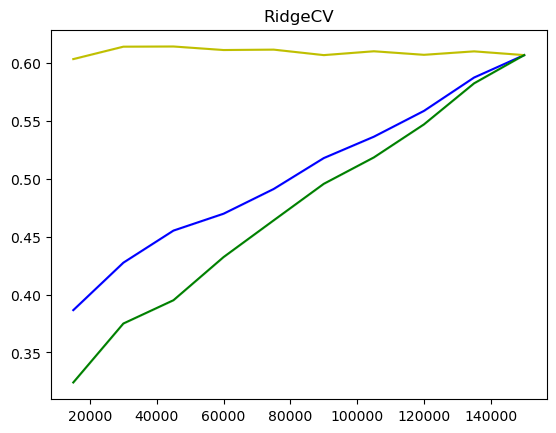

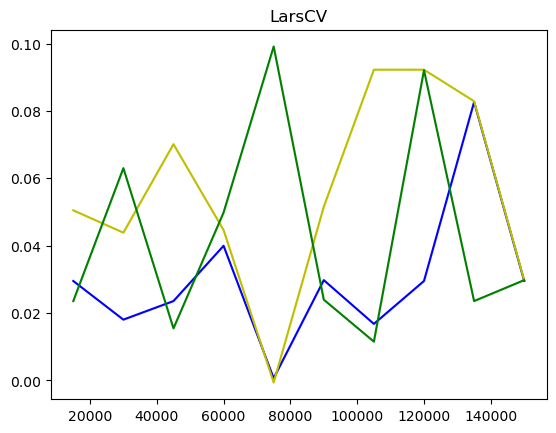

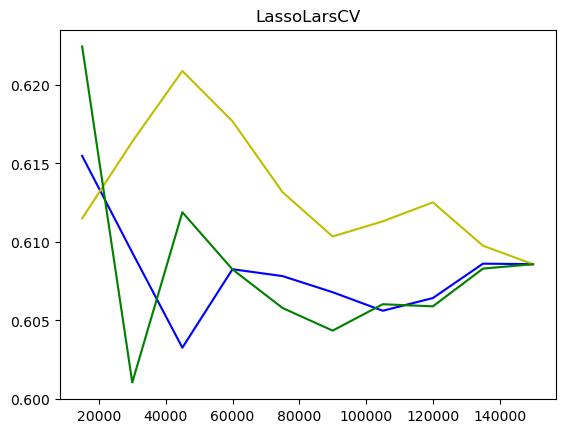

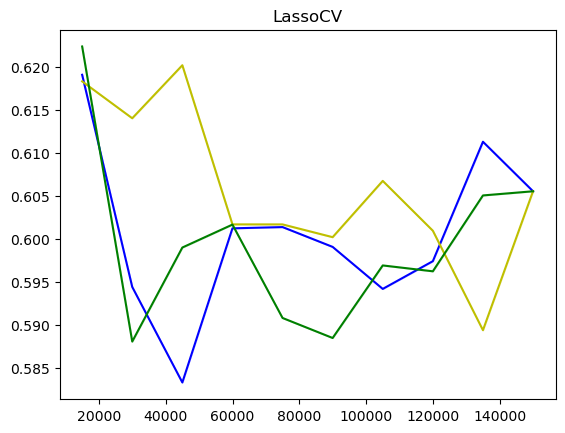

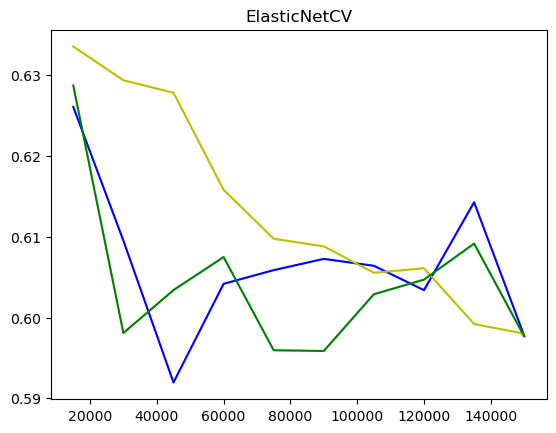

In [11]:
import os


def plot_results(_plt, fun_name):
    if os.path.isfile(
            r"./ABIDE_poly3_predict_age/ABIDE_poly3_age_MI_epa_scott_{fun_name}.npy"
            .format(fun_name=fun_name)
    ) and os.path.isfile(
            r"./ABIDE_poly3_predict_age/ABIDE_poly3_age_skMI_{fun_name}.npy".
            format(fun_name=fun_name)
    ) and os.path.isfile(
            r"./ABIDE_poly3_predict_age/ABIDE_poly3_age_Pearson_{fun_name}.npy"
            .format(fun_name=fun_name)):
        columns = np.load(r"./ABIDE_columns.npy")
        ABIDE_age_MI_foo = np.load(
            r"./ABIDE_poly3_predict_age/ABIDE_poly3_age_MI_epa_scott_{fun_name}.npy"
            .format(fun_name=fun_name))
        ABIDE_age_skMI_foo = np.load(
            r"./ABIDE_poly3_predict_age/ABIDE_poly3_age_skMI_{fun_name}.npy".
            format(fun_name=fun_name))
        ABIDE_age_Pearson_foo = np.load(
            r"./ABIDE_poly3_predict_age/ABIDE_poly3_age_Pearson_{fun_name}.npy"
            .format(fun_name=fun_name))
        num_attr = list(
            map(int,
                np.around(np.linspace(
                    0, len(columns), 10 +
                    1)[1:]).tolist()))  # ADJUST this based on actual settings

        MI_fit_mean = np.mean(ABIDE_age_MI_foo, 1)
        MI_fit_std = np.std(ABIDE_age_MI_foo, 1)
        skMI_fit_mean = np.mean(ABIDE_age_skMI_foo, 1)
        skMI_fit_std = np.std(ABIDE_age_skMI_foo, 1)
        Pearson_fit_mean = np.mean(ABIDE_age_Pearson_foo, 1)
        Pearson_fit_std = np.std(ABIDE_age_Pearson_foo, 1)

        _plt.plot(num_attr, MI_fit_mean, label="Mutual Information", color="b")
        _plt.fill_between(num_attr,
                          (MI_fit_mean + MI_fit_std * norm.ppf(0.025)),
                          (MI_fit_mean + MI_fit_std * norm.ppf(0.975)),
                          color="b",
                          alpha=.1)

        _plt.plot(num_attr,
                  skMI_fit_mean,
                  label="Mutual Information by skLearn",
                  color="y")
        _plt.fill_between(num_attr,
                          (skMI_fit_mean + skMI_fit_std * norm.ppf(0.025)),
                          (skMI_fit_mean + skMI_fit_std * norm.ppf(0.975)),
                          color="y",
                          alpha=.1)

        _plt.plot(num_attr,
                  Pearson_fit_mean,
                  label="Pearson Correlation",
                  color="g")
        _plt.fill_between(
            num_attr, (Pearson_fit_mean + Pearson_fit_std * norm.ppf(0.025)),
            (Pearson_fit_mean + Pearson_fit_std * norm.ppf(0.975)),
            color="g",
            alpha=.1)
        _plt.title(fun_name)


for fun_name in [
        "MLPRegressor", "RidgeCV", "LarsCV", "LassoLarsCV", "LassoCV",
        "ElasticNetCV", "RandomForestRegressor"
]:
    plot_results(plt, fun_name)
    plt.show()

# Try Fitting models to predict diagnosis, $5$-fold CV
## this block of code only means to be run on Compute Canada
### `ABIDE_predict_diagnosis`

In [12]:
from pathlib import Path


def job_creator(dep_measure, fun_name):
    Path(r"./ABIDE_predict_diagnosis/ABIDE_diagnosis_" + dep_measure + "_" +
         fun_name + ".sh").touch()
    Path(r"./ABIDE_predict_diagnosis/ABIDE_diagnosis_" + dep_measure + "_" +
         fun_name + ".py").touch()
    bash_script = open(
        r"./ABIDE_predict_diagnosis/ABIDE_diagnosis_" + dep_measure + "_" +
        fun_name + ".sh", "w")
    py_script = open(
        r"./ABIDE_predict_diagnosis/ABIDE_diagnosis_" + dep_measure + "_" +
        fun_name + ".py", "w")
    bash_script.write(r"""#!/bin/bash
#SBATCH --account=def-cgreenwo
#SBATCH --nodes=1
#SBATCH --cpus-per-task=10
#SBATCH --mem=80G
#SBATCH --time=0-22:00:00
#SBATCH --job-name=diagnosis_{dep_measure}_{fun_name}

module load gcc llvm rust arrow cuda nodejs python/3.8.10 r/4.0.2 python-build-bundle

virtualenv --no-download $SLURM_TMPDIR/env
source $SLURM_TMPDIR/env/bin/activate
pip install --no-index --upgrade pip

# ### run this block at the login node to build wheels
# ### get wheels builder
# git clone https://github.com/ComputeCanada/wheels_builder
# export PATH=$PATH:${{HOME}}/wheels_builder
# ### build KDEpy 1.1.0
# ${{HOME}}/wheels_builder/unmanylinuxize.sh --package KDEpy --version 1.1.0 --python 3.8,3.9,3.10 --find_links https://files.pythonhosted.org/packages/
# ### built nonconvexAG 1.0.6
# ${{HOME}}/wheels_builder/unmanylinuxize.sh --package nonconvexAG --version 1.0.6 --python 3.8,3.9,3.10 --find_links https://files.pythonhosted.org/packages/
# ### built fastHDMI 1.18.20
# ${{HOME}}/wheels_builder/unmanylinuxize.sh --package fastHDMI --version 1.18.20 --python 3.8,3.9,3.10 --find_links https://files.pythonhosted.org/packages/

# Here basically to build the packages at login node and install them in slurm job submission locally
pip install --no-index bed-reader numpy sklearn matplotlib scipy numba multiprocess scikit-learn cupy rpy2
pip install --no-index /home/kyang/KDEpy-1.1.0+computecanada-cp38-cp38-linux_x86_64.whl
pip install --no-index /home/kyang/nonconvexAG-1.0.6+computecanada-py3-none-any.whl
pip install --no-index /home/kyang/fastHDMI-1.18.20+computecanada-py3-none-any.whl

nvidia-smi
lscpu

echo "running ABIDE_diagnosis_{dep_measure}_{fun_name}.py"

cp /home/kyang/projects/def-cgreenwo/abide_data/abide_fs60_vout_fwhm0_lh_SubjectIDFormatted_N1050_nonzero_withSEX.csv $SLURM_TMPDIR/
cp ../ABIDE_columns.npy $SLURM_TMPDIR/
cp ../ABIDE_diagnosis_{dep_measure}_output.npy $SLURM_TMPDIR/

python3 ABIDE_diagnosis_{dep_measure}_{fun_name}.py
    """.format(dep_measure=dep_measure, fun_name=fun_name))
    py_script.write(r"""import numpy as np
import pandas as pd
from dask import dataframe as dd
import matplotlib.pyplot as plt
from scipy.stats import kendalltau, rankdata, norm
import fastHDMI as mi
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, SplineTransformer
from sklearn.linear_model import LassoCV, ElasticNetCV, RidgeCV, LarsCV, LassoLarsCV, LogisticRegressionCV
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, roc_auc_score
import multiprocess as mp
from tqdm import tqdm
import os

csv_file = os.environ["SLURM_TMPDIR"] + \
    r"/abide_fs60_vout_fwhm0_lh_SubjectIDFormatted_N1050_nonzero_withSEX.csv"
original_df = pd.read_csv(csv_file, encoding="unicode_escape", engine="c")

columns = np.load(os.environ["SLURM_TMPDIR"] + r"/ABIDE_columns.npy")
abide_dep = np.load(
    os.environ["SLURM_TMPDIR"] +
    r"/ABIDE_diagnosis_{dep_measure}_output.npy")  # dep_measure
abide_dep = np.absolute(abide_dep)


def LogisticRegressionCV_l1(**arg):
    return LogisticRegressionCV(penalty="l1",
                                solver="saga",
                                multi_class="ovr",
                                **arg)


def LogisticRegressionCV_l2(**arg):
    return LogisticRegressionCV(penalty="l2",
                                solver="lbfgs",
                                multi_class="ovr",
                                **arg)


def LogisticRegressionCV_ElasticNet(**arg):
    return LogisticRegressionCV(penalty="elasticnet",
                                solver="saga",
                                multi_class="ovr",
                                l1_ratios=np.linspace(0, 1, 12)[1:-1],
                                **arg)


def testing_error(num_covariates=20,
                  training_proportion=.8,
                  fun=ElasticNetCV,
                  outcome_name="AGE_AT_SCAN",
                  seed=1):
    np.random.seed(seed)
    _usecols = np.hstack((outcome_name, "SEX", "AGE_AT_SCAN",
                          columns[np.argsort(-abide_dep)][:num_covariates]))
    df = original_df[_usecols].dropna(inplace=False).sample(
        frac=1, random_state=seed, replace=False).reset_index(drop=True,
                                                              inplace=False)
    if df.shape[0] > 20:
        X, y = df.iloc[:,
                       1:].to_numpy(copy=True), df.iloc[:,
                                                        0].to_numpy(copy=True)
        X = StandardScaler(copy=False).fit_transform(X)
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, train_size=training_proportion, random_state=seed)
        if fun in [ElasticNetCV, LassoCV]:
            fit = fun(cv=5, random_state=seed, n_jobs=10).fit(X_train, y_train)
            y_pred = fit.predict(X_test)
            out = r2_score(y_test, y_pred)
        elif fun in [RidgeCV]:  # RidgeCV doesn't have seed setting and n_jobs
            fit = fun(cv=5).fit(X_train, y_train)
            y_pred = fit.predict(X_test)
            out = r2_score(y_test, y_pred)
        elif fun in [LarsCV, LassoLarsCV
                     ]:  # LarsCV doesn't have seed setting but have n_jobs
            fit = fun(cv=5, n_jobs=10).fit(X_train, y_train)
            y_pred = fit.predict(X_test)
            out = r2_score(y_test, y_pred)
        elif fun in [MLPRegressor]:
            mlp_gs = fun(random_state=seed, max_iter=500)
            parameter_space = {{
                "hidden_layer_sizes": [(15, 15, 15, 15, 15, 15), (30, 20, 20), (500, )],
                "activation": ["tanh", "relu"],
                "solver": ["sgd", "adam"],
                "alpha": [0.0001, 0.05],
                "learning_rate": ["constant", "adaptive"]
            }}
            clf = GridSearchCV(mlp_gs, parameter_space, n_jobs=10, cv=5)
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            out = r2_score(y_test, y_pred)
        elif fun in [MLPClassifier]:
            mlp_gs = fun(random_state=seed, max_iter=500)
            parameter_space = {{
                "hidden_layer_sizes": [(15, 15, 15, 15, 15, 15), (30, 20, 20), (500, )],
                "activation": ["tanh", "relu"],
                "solver": ["sgd", "adam"],
                "alpha": [0.0001, 0.05],
                "learning_rate": ["constant", "adaptive"]
            }}
            clf = GridSearchCV(mlp_gs, parameter_space, n_jobs=10, cv=5)
            clf.fit(X_train, y_train)
            y_pred = clf.predict_proba(
                X_test)[:, 1]  # predict probability to calculate ROC
            out = roc_auc_score(y_test, y_pred)
        elif fun in [
                LogisticRegressionCV_l1, LogisticRegressionCV_l2,
                LogisticRegressionCV_ElasticNet
        ]:
            fit = fun(cv=5, random_state=seed, n_jobs=10).fit(X_train, y_train)
            y_pred = fit.predict_proba(
                X_test)[:, 1]  # predict probability to calculate ROC
            out = roc_auc_score(y_test, y_pred)
        elif fun in [RandomForestRegressor]:
            fit = fun(random_state=seed, n_jobs=10).fit(X_train, y_train)
            y_pred = fit.predict(X_test)
            out = r2_score(y_test, y_pred)
        elif fun in [RandomForestClassifier]:
            fit = fun(random_state=seed, n_jobs=10).fit(X_train, y_train)
            y_pred = fit.predict_proba(X_test)[:, 1]  # predict probability to calculate ROC
            out = roc_auc_score(y_test, y_pred)
    else:
        out = np.nan
    return out


def testing_error_rep(num_covariates=20,
                      training_proportion=.8,
                      fun=ElasticNetCV,
                      outcome_name="AGE_AT_SCAN",
                      num_rep=10):
    def _testing_error(seed):
        return testing_error(num_covariates=num_covariates,
                             training_proportion=training_proportion,
                             fun=fun,
                             outcome_name=outcome_name,
                             seed=seed)

    seeds = np.arange(num_rep)
    return np.array(list(map(_testing_error, seeds)))


def testing_error_num_attr(num_attr,
                           training_proportion=.8,
                           fun=ElasticNetCV,
                           outcome_name="AGE_AT_SCAN",
                           num_rep=10):
    def _testing_error_rep(_num_attr):
        return testing_error_rep(num_covariates=_num_attr,
                                 training_proportion=training_proportion,
                                 fun=fun,
                                 outcome_name=outcome_name,
                                 num_rep=num_rep)

    return np.array(list(map(_testing_error_rep, tqdm(num_attr))))


print(r"ABIDE_age_{dep_measure}_{fun_name}")  # dep_measure, fun_name
output = testing_error_num_attr(
    num_attr=list(
        map(int,
            np.around(np.linspace(0, len(columns), 10 + 1)[1:]).tolist())),
    training_proportion=.8,  # 80/20 training+validation/testing division
    fun={fun_name},  # fun_name
    outcome_name="DX_GROUP",
    num_rep=1)
np.save(r"./ABIDE_diagnosis_{dep_measure}_{fun_name}",
        output)  # dep_measure, fun_name
    """.format(dep_measure=dep_measure, fun_name=fun_name))


dep_measure_list = []
for _kernel in [
        'gaussian', 'exponential', 'box', 'tri', 'epa', 'biweight',
        'triweight', 'tricube', 'cosine'
]:
    for _bw in ['silverman', 'scott', 'ISJ']:
        dep_measure_list += ["MI_{kernel}_{bw}".format(kernel=_kernel, bw=_bw)]

for fun_name in [
        "LogisticRegressionCV_l1", "LogisticRegressionCV_l2",
        "LogisticRegressionCV_ElasticNet", "MLPClassifier",
        "RandomForestClassifier"
]:
    for dep_measure in [*dep_measure_list, "Pearson", "skMI"]:
        job_creator(dep_measure, fun_name)

In [13]:
#!find . -name "*.py" -exec yapf --in-place "{}" \;
#!find . -name "*.py" -exec autopep8 --in-place "{}" \;
# !find . -name "*.py" -exec yapf --in-place "{}" \;
# !find . -name "*.py" -exec autopep8 --in-place "{}" \;

### `ABIDE_poly3_predict_diagnosis`

In [14]:
from pathlib import Path


def job_creator(dep_measure, fun_name):
    Path(r"./ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_" +
         dep_measure + "_" + fun_name + ".sh").touch()
    Path(r"./ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_" +
         dep_measure + "_" + fun_name + ".py").touch()
    bash_script = open(
        r"./ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_" +
        dep_measure + "_" + fun_name + ".sh", "w")
    py_script = open(
        r"./ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_" +
        dep_measure + "_" + fun_name + ".py", "w")
    bash_script.write(r"""#!/bin/bash
#SBATCH --account=def-masd
#SBATCH --nodes=1
#SBATCH --cpus-per-task=10
#SBATCH --mem=80G
#SBATCH --time=0-22:00:00
#SBATCH --job-name=poly3_diagnosis_{dep_measure}_{fun_name}

module load gcc llvm rust arrow cuda nodejs python/3.8.10 r/4.0.2 python-build-bundle

virtualenv --no-download $SLURM_TMPDIR/env
source $SLURM_TMPDIR/env/bin/activate
pip install --no-index --upgrade pip

# ### run this block at the login node to build wheels
# ### get wheels builder
# git clone https://github.com/ComputeCanada/wheels_builder
# export PATH=$PATH:${{HOME}}/wheels_builder
# ### build KDEpy 1.1.0
# ${{HOME}}/wheels_builder/unmanylinuxize.sh --package KDEpy --version 1.1.0 --python 3.8,3.9,3.10 --find_links https://files.pythonhosted.org/packages/
# ### built nonconvexAG 1.0.6
# ${{HOME}}/wheels_builder/unmanylinuxize.sh --package nonconvexAG --version 1.0.6 --python 3.8,3.9,3.10 --find_links https://files.pythonhosted.org/packages/
# ### built fastHDMI 1.18.20
# ${{HOME}}/wheels_builder/unmanylinuxize.sh --package fastHDMI --version 1.18.20 --python 3.8,3.9,3.10 --find_links https://files.pythonhosted.org/packages/

# Here basically to build the packages at login node and install them in slurm job submission locally
pip install --no-index bed-reader numpy sklearn matplotlib scipy numba multiprocess scikit-learn cupy rpy2
pip install --no-index /home/kyang/KDEpy-1.1.0+computecanada-cp38-cp38-linux_x86_64.whl
pip install --no-index /home/kyang/nonconvexAG-1.0.6+computecanada-py3-none-any.whl
pip install --no-index /home/kyang/fastHDMI-1.18.20+computecanada-py3-none-any.whl

nvidia-smi
lscpu

echo "running ABIDE_poly3_diagnosis_{dep_measure}_{fun_name}.py"

cp /home/kyang/projects/def-cgreenwo/abide_data/abide_fs60_vout_fwhm0_lh_SubjectIDFormatted_N1050_nonzero_withSEX.csv $SLURM_TMPDIR/
cp ../ABIDE_columns.npy $SLURM_TMPDIR/
cp ../ABIDE_diagnosis_{dep_measure}_output.npy $SLURM_TMPDIR/

python3 ABIDE_poly3_diagnosis_{dep_measure}_{fun_name}.py
    """.format(dep_measure=dep_measure, fun_name=fun_name))
    py_script.write(r"""import numpy as np
import pandas as pd
from dask import dataframe as dd
import matplotlib.pyplot as plt
from scipy.stats import kendalltau, rankdata, norm
import fastHDMI as mi
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, SplineTransformer
from sklearn.linear_model import LassoCV, ElasticNetCV, RidgeCV, LarsCV, LassoLarsCV, LogisticRegressionCV
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, roc_auc_score
import multiprocess as mp
from tqdm import tqdm
import os

csv_file = os.environ["SLURM_TMPDIR"] + \
    r"/abide_fs60_vout_fwhm0_lh_SubjectIDFormatted_N1050_nonzero_withSEX.csv"
original_df = pd.read_csv(csv_file, encoding="unicode_escape", engine="c")

columns = np.load(os.environ["SLURM_TMPDIR"] + r"/ABIDE_columns.npy")
abide_dep = np.load(
    os.environ["SLURM_TMPDIR"] +
    r"/ABIDE_diagnosis_{dep_measure}_output.npy")  # dep_measure
abide_dep = np.absolute(abide_dep)


def LogisticRegressionCV_l1(**arg):
    return LogisticRegressionCV(penalty="l1",
                                solver="saga",
                                multi_class="ovr",
                                **arg)


def LogisticRegressionCV_l2(**arg):
    return LogisticRegressionCV(penalty="l2",
                                solver="lbfgs",
                                multi_class="ovr",
                                **arg)


def LogisticRegressionCV_ElasticNet(**arg):
    return LogisticRegressionCV(penalty="elasticnet",
                                solver="saga",
                                multi_class="ovr",
                                l1_ratios=np.linspace(0, 1, 12)[1:-1],
                                **arg)


def testing_error(num_covariates=20,
                  training_proportion=.8,
                  fun=ElasticNetCV,
                  outcome_name="AGE_AT_SCAN",
                  seed=1):
    np.random.seed(seed)
    _usecols = np.hstack((outcome_name, "SEX", "AGE_AT_SCAN",
                          columns[np.argsort(-abide_dep)][:num_covariates]))
    df = original_df[_usecols].dropna(inplace=False).sample(
        frac=1, random_state=seed, replace=False).reset_index(drop=True,
                                                              inplace=False)
    if df.shape[0] > 20:
        X, y = df.iloc[:,
                       1:].to_numpy(copy=True), df.iloc[:,
                                                        0].to_numpy(copy=True)
        X = StandardScaler(copy=False).fit_transform(X)
        X = SplineTransformer(n_knots=2,
                              degree=3,
                              extrapolation="continue",
                              include_bias=False).fit_transform(X)
        X = StandardScaler(copy=False).fit_transform(X)
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, train_size=training_proportion, random_state=seed)
        if fun in [ElasticNetCV, LassoCV]:
            fit = fun(cv=5, random_state=seed, n_jobs=10).fit(X_train, y_train)
            y_pred = fit.predict(X_test)
            out = r2_score(y_test, y_pred)
        elif fun in [RidgeCV]:  # RidgeCV doesn't have seed setting and n_jobs
            fit = fun(cv=5).fit(X_train, y_train)
            y_pred = fit.predict(X_test)
            out = r2_score(y_test, y_pred)
        elif fun in [LarsCV, LassoLarsCV
                     ]:  # LarsCV doesn't have seed setting but have n_jobs
            fit = fun(cv=5, n_jobs=10).fit(X_train, y_train)
            y_pred = fit.predict(X_test)
            out = r2_score(y_test, y_pred)
        elif fun in [MLPRegressor]:
            mlp_gs = fun(random_state=seed, max_iter=500)
            parameter_space = {{
                "hidden_layer_sizes": [(15, 15, 15, 15, 15, 15), (30, 20, 20), (500, )],
                "activation": ["tanh", "relu"],
                "solver": ["sgd", "adam"],
                "alpha": [0.0001, 0.05],
                "learning_rate": ["constant", "adaptive"]
            }}
            clf = GridSearchCV(mlp_gs, parameter_space, n_jobs=10, cv=5)
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            out = r2_score(y_test, y_pred)
        elif fun in [MLPClassifier]:
            mlp_gs = fun(random_state=seed, max_iter=500)
            parameter_space = {{
                "hidden_layer_sizes": [(15, 15, 15, 15, 15, 15), (30, 20, 20), (500, )],
                "activation": ["tanh", "relu"],
                "solver": ["sgd", "adam"],
                "alpha": [0.0001, 0.05],
                "learning_rate": ["constant", "adaptive"]
            }}
            clf = GridSearchCV(mlp_gs, parameter_space, n_jobs=10, cv=5)
            clf.fit(X_train, y_train)
            y_pred = clf.predict_proba(
                X_test)[:, 1]  # predict probability to calculate ROC
            out = roc_auc_score(y_test, y_pred)
        elif fun in [
                LogisticRegressionCV_l1, LogisticRegressionCV_l2,
                LogisticRegressionCV_ElasticNet
        ]:
            fit = fun(cv=5, random_state=seed, n_jobs=10).fit(X_train, y_train)
            y_pred = fit.predict_proba(
                X_test)[:, 1]  # predict probability to calculate ROC
            out = roc_auc_score(y_test, y_pred)
        elif fun in [RandomForestRegressor]:
            fit = fun(random_state=seed, n_jobs=10).fit(X_train, y_train)
            y_pred = fit.predict(X_test)
            out = r2_score(y_test, y_pred)
        elif fun in [RandomForestClassifier]:
            fit = fun(random_state=seed, n_jobs=10).fit(X_train, y_train)
            y_pred = fit.predict_proba(X_test)[:, 1]  # predict probability to calculate ROC
            out = roc_auc_score(y_test, y_pred)
    else:
        out = np.nan
    return out


def testing_error_rep(num_covariates=20,
                      training_proportion=.8,
                      fun=ElasticNetCV,
                      outcome_name="AGE_AT_SCAN",
                      num_rep=10):
    def _testing_error(seed):
        return testing_error(num_covariates=num_covariates,
                             training_proportion=training_proportion,
                             fun=fun,
                             outcome_name=outcome_name,
                             seed=seed)

    seeds = np.arange(num_rep)
    return np.array(list(map(_testing_error, seeds)))


def testing_error_num_attr(num_attr,
                           training_proportion=.8,
                           fun=ElasticNetCV,
                           outcome_name="AGE_AT_SCAN",
                           num_rep=10):
    def _testing_error_rep(_num_attr):
        return testing_error_rep(num_covariates=_num_attr,
                                 training_proportion=training_proportion,
                                 fun=fun,
                                 outcome_name=outcome_name,
                                 num_rep=num_rep)

    return np.array(list(map(_testing_error_rep, tqdm(num_attr))))


print(r"ABIDE_poly3_age_{dep_measure}_{fun_name}")  # dep_measure, fun_name
output = testing_error_num_attr(
    num_attr=list(
        map(int,
            np.around(np.linspace(0, len(columns), 10 + 1)[1:]).tolist())),
    training_proportion=.8,  # 80/20 training+validation/testing division
    fun={fun_name},  # fun_name
    outcome_name="DX_GROUP",
    num_rep=1)
np.save(r"./ABIDE_poly3_diagnosis_{dep_measure}_{fun_name}",
        output)  # dep_measure, fun_name
    """.format(dep_measure=dep_measure, fun_name=fun_name))


dep_measure_list = []
for _kernel in [
        'gaussian', 'exponential', 'box', 'tri', 'epa', 'biweight',
        'triweight', 'tricube', 'cosine'
]:
    for _bw in ['silverman', 'scott', 'ISJ']:
        dep_measure_list += ["MI_{kernel}_{bw}".format(kernel=_kernel, bw=_bw)]

for fun_name in [
        "LogisticRegressionCV_l1", "LogisticRegressionCV_l2",
        "LogisticRegressionCV_ElasticNet", "MLPClassifier",
        "RandomForestClassifier"
]:
    for dep_measure in [*dep_measure_list, "Pearson", "skMI"]:
        job_creator(dep_measure, fun_name)

In [15]:
# #!find . -name "*.py" -exec yapf --in-place "{}" \;
#!find . -name "*.py" -exec autopep8 --in-place "{}" \;
!find . -name "*.py" -exec yapf --in-place "{}" \;
!find . -name "*.py" -exec autopep8 --in-place "{}" \;

# Comparison of Performance
## Here is just to show the testing set ROC

In [16]:
import os


def plot_results(_plt, fun_name):
    if os.path.isfile(
            r"./ABIDE_predict_diagnosis/ABIDE_diagnosis_MI_{fun_name}.npy".
            format(fun_name=fun_name)
    ) and os.path.isfile(
            r"./ABIDE_predict_diagnosis/ABIDE_diagnosis_skMI_{fun_name}.npy".
            format(fun_name=fun_name)
    ) and os.path.isfile(
            r"./ABIDE_predict_diagnosis/ABIDE_diagnosis_Pearson_{fun_name}.npy"
            .format(fun_name=fun_name)):
        columns = np.load(r"./ABIDE_columns.npy")
        ABIDE_diagnosis_MI_foo = np.load(
            r"./ABIDE_predict_diagnosis/ABIDE_diagnosis_MI_{fun_name}.npy".
            format(fun_name=fun_name))
        ABIDE_diagnosis_skMI_foo = np.load(
            r"./ABIDE_predict_diagnosis/ABIDE_diagnosis_skMI_{fun_name}.npy".
            format(fun_name=fun_name))
        ABIDE_diagnosis_Pearson_foo = np.load(
            r"./ABIDE_predict_diagnosis/ABIDE_diagnosis_Pearson_{fun_name}.npy"
            .format(fun_name=fun_name))
        num_attr = list(
            map(int,
                np.around(np.linspace(
                    0, len(columns), 10 +
                    1)[1:]).tolist()))  # ADJUST this based on actual settings

        MI_fit_mean = np.mean(ABIDE_diagnosis_MI_foo, 1)
        MI_fit_std = np.std(ABIDE_diagnosis_MI_foo, 1)
        skMI_fit_mean = np.mean(ABIDE_diagnosis_skMI_foo, 1)
        skMI_fit_std = np.std(ABIDE_diagnosis_skMI_foo, 1)
        Pearson_fit_mean = np.mean(ABIDE_diagnosis_Pearson_foo, 1)
        Pearson_fit_std = np.std(ABIDE_diagnosis_Pearson_foo, 1)

        _plt.plot(num_attr, MI_fit_mean, label="Mutual Information", color="b")
        _plt.fill_between(num_attr,
                          (MI_fit_mean + MI_fit_std * norm.ppf(0.025)),
                          (MI_fit_mean + MI_fit_std * norm.ppf(0.975)),
                          color="b",
                          alpha=.1)

        _plt.plot(num_attr,
                  skMI_fit_mean,
                  label="Mutual Information",
                  color="y")
        _plt.fill_between(num_attr,
                          (skMI_fit_mean + skMI_fit_std * norm.ppf(0.025)),
                          (skMI_fit_mean + skMI_fit_std * norm.ppf(0.975)),
                          color="y",
                          alpha=.1)

        _plt.plot(num_attr,
                  Pearson_fit_mean,
                  label="Pearson Correlation",
                  color="g")
        _plt.fill_between(
            num_attr, (Pearson_fit_mean + Pearson_fit_std * norm.ppf(0.025)),
            (Pearson_fit_mean + Pearson_fit_std * norm.ppf(0.975)),
            color="g",
            alpha=.1)
        _plt.title(fun_name)


for fun_name in [
        "MLPClassifier", "LogisticRegressionCV_l2", "LogisticRegressionCV_l1",
        "LogisticRegressionCV_ElasticNet", "RandomForestClassifier"
]:
    plot_results(plt, fun_name)
    plt.show()

In [17]:
import os


def plot_results(_plt, fun_name):
    if os.path.isfile(
            r"./ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_MI_{fun_name}.npy"
            .format(fun_name=fun_name)
    ) and os.path.isfile(
            r"./ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_skMI_{fun_name}.npy"
            .format(fun_name=fun_name)
    ) and os.path.isfile(
            r"./ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_Pearson_{fun_name}.npy"
            .format(fun_name=fun_name)):
        columns = np.load(r"./ABIDE_columns.npy")
        ABIDE_diagnosis_MI_foo = np.load(
            r"./ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_MI_{fun_name}.npy"
            .format(fun_name=fun_name))
        ABIDE_diagnosis_skMI_foo = np.load(
            r"./ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_skMI_{fun_name}.npy"
            .format(fun_name=fun_name))
        ABIDE_diagnosis_Pearson_foo = np.load(
            r"./ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_Pearson_{fun_name}.npy"
            .format(fun_name=fun_name))
        num_attr = list(
            map(int,
                np.around(np.linspace(
                    0, len(columns), 10 +
                    1)[1:]).tolist()))  # ADJUST this based on actual settings

        MI_fit_mean = np.mean(ABIDE_diagnosis_MI_foo, 1)
        MI_fit_std = np.std(ABIDE_diagnosis_MI_foo, 1)
        skMI_fit_mean = np.mean(ABIDE_diagnosis_skMI_foo, 1)
        skMI_fit_std = np.std(ABIDE_diagnosis_skMI_foo, 1)
        Pearson_fit_mean = np.mean(ABIDE_diagnosis_Pearson_foo, 1)
        Pearson_fit_std = np.std(ABIDE_diagnosis_Pearson_foo, 1)

        _plt.plot(num_attr, MI_fit_mean, label="Mutual Information", color="b")
        _plt.fill_between(num_attr,
                          (MI_fit_mean + MI_fit_std * norm.ppf(0.025)),
                          (MI_fit_mean + MI_fit_std * norm.ppf(0.975)),
                          color="b",
                          alpha=.1)

        _plt.plot(num_attr,
                  skMI_fit_mean,
                  label="Mutual Information",
                  color="y")
        _plt.fill_between(num_attr,
                          (skMI_fit_mean + skMI_fit_std * norm.ppf(0.025)),
                          (skMI_fit_mean + skMI_fit_std * norm.ppf(0.975)),
                          color="y",
                          alpha=.1)

        _plt.plot(num_attr,
                  Pearson_fit_mean,
                  label="Pearson Correlation",
                  color="g")
        _plt.fill_between(
            num_attr, (Pearson_fit_mean + Pearson_fit_std * norm.ppf(0.025)),
            (Pearson_fit_mean + Pearson_fit_std * norm.ppf(0.975)),
            color="g",
            alpha=.1)
        _plt.title(fun_name)


for fun_name in [
        "MLPClassifier", "LogisticRegressionCV_l2", "LogisticRegressionCV_l1",
        "LogisticRegressionCV_ElasticNet", "RandomForestClassifier"
]:
    plot_results(plt, fun_name)
    plt.show()